In [90]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi, SNLE
from sbi.utils.posterior_ensemble import NeuralPosteriorEnsemble
import numpy as np
import moments

from matplotlib import pyplot as plt
import dill
import os
import seaborn as sns
from joblib import Parallel, delayed
from sbi.inference import infer
import logging
from sbi.utils import get_density_thresholder, RestrictedPrior
import seaborn as sns
import matplotlib.pyplot as plt
logging.getLogger('matplotlib').setLevel(logging.ERROR) # See: https://github.com/matplotlib/matplotlib/issues/14523
import torch.nn.functional as F


In [2]:
post_observed_65 = torch.load('/home/rahul/PopGen/SimulationSFS/ClusterData/Finnish/Demo/posterior_observed_round_65.pkl')

In [3]:
post_observed_65

VIPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [131]:
# Box-uniform prior
box_uniform_prior = utils.BoxUniform(low=-800.0 * torch.ones(1), high=1.0 * torch.ones(1))

# Get Restricted proposal

print("Creating restricted proposal")
accept_reject_fn = get_density_thresholder(post_observed_65, quantile=1e-6, num_samples_to_estimate_support = 10_000_000)
restricted_proposal_finnish_no_demo = RestrictedPrior(box_uniform_prior, accept_reject_fn, posterior=post_observed_65, sample_with="sir", device='cpu')
print("Finished creating restricted proposal")

Creating restricted proposal
Finished creating restricted proposal


In [132]:
rest_samples = restricted_proposal_finnish_no_demo.sample((1000,))

<AxesSubplot: ylabel='Density'>

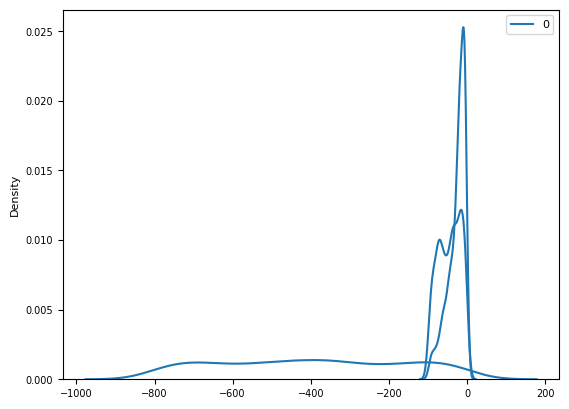

In [133]:
sns.kdeplot(rest_samples)
sns.kdeplot(post_observed_65.sample((1000,)))
sns.kdeplot(box_uniform_prior.sample((1000,)))

In [147]:
def moment_sim_no_demo(prior: float) -> torch.float32:
    """Uses Moments (cite) to create simulated Site Frequency Spectrums in a constant population size

    Args:
        prior (float): a sampled selection distribution from a prior distribution

    Returns:
        x: The sampled site-frequency spectrum based on moments via Poisson(E[X | gamma]) where gamma = prior
        Output of the simulator needs to be float32 based on SBI format 
    """    
    
    moment_data =  moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(sample_size, gamma=prior, theta=5000.0))  # returns a masked array
    
    # masked arrays are objects and data is accessed through .data attribute or valid data through .compressed()
    actual_fs = moment_data.compressed()
    x = torch.poisson(torch.tensor(actual_fs, device='cpu')).type(torch.float32)
        
    return x

In [148]:
simulator_finnish_no_demo = process_simulator(moment_sim_no_demo, box_uniform_prior, prior_returns_numpy)


In [149]:
xx_no_demo_finnish = simulator_finnish_no_demo(restricted_proposal_finnish_no_demo.sample((200,)))

In [150]:
D=list(range(1, 100, 10))
x_no_pp2 = xx_no_demo_finnish[:, D]


In [151]:
x_no_pp2[1, :10]

tensor([2429.,  384.,  190.,  118.,   98.,   65.,   75.,   46.,   32.,   32.])

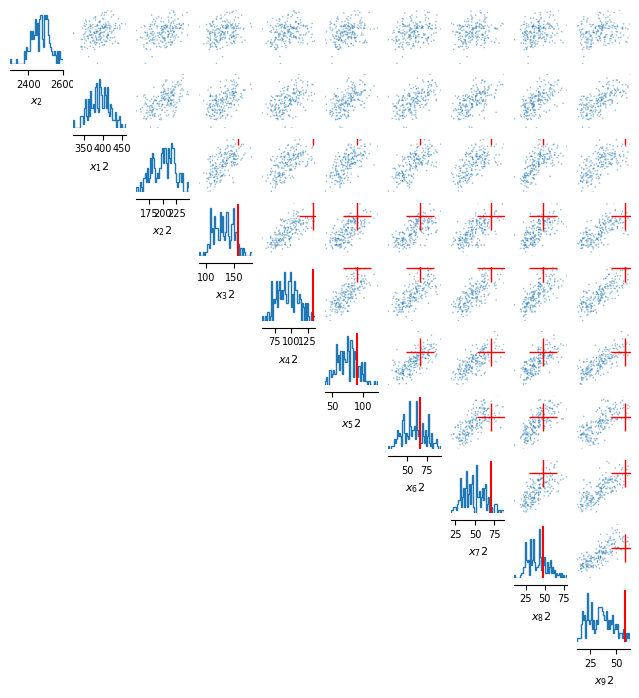

In [152]:
_ = pairplot(
    samples=x_no_pp2,
    points=x_o2,
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=20),
    labels=[rf"$x_{d+1}$" for d in D],)

In [17]:

post_observed_65_no_demo = torch.load('/home/rahul/PopGen/SimulationSFS/ClusterData/Finnish/Demo/posterior_observed_round_65_without_demo.pkl')

In [18]:
print("Creating restricted proposal")
accept_reject_fn = get_density_thresholder(post_observed_65_no_demo, quantile=1e-6, num_samples_to_estimate_support = 10_000_000)
restricted_proposal_no_demo = RestrictedPrior(box_uniform_prior, accept_reject_fn, posterior=post_observed_65, sample_with="sir", device='cpu')
print("Finished creating restricted proposal")

Creating restricted proposal
Finished creating restricted proposal


In [59]:
def get_true_data(sample_size: int, a_path: str) -> torch.float32:
    """Gets the true Site-Frequency Spectrum 

    Args:
        path (str): Where the true-SFS is located, must be a text file with separated by columns, the last column represents the Allele count

    Returns:
        Returns the SFS of the true-data set
    """   
    loaded_file = np.loadtxt(a_path)
    ac_count = loaded_file[:,-1].astype(int) # get last column which is the frequency of the alternate/derived allele
    # only get sites > 0
    ac_count = ac_count[np.nonzero(ac_count)]
    thebins = np.arange(1,sample_size+1) # (+1) so that the returned histogram is the same shape as sample_size-1
    # Get the histogram
    sfs, _ = np.histogram(ac_count, bins=thebins)  
    assert sfs.shape[0] == sample_size-1, "Sample Size must be the same dimensions as the Site Frequency Spectrum, SFS shape: {} and sample shape: {}".format(sfs.shape[0], sample_size)

    return torch.tensor(sfs, device='cpu').type(torch.float32)

In [108]:
finnish_sample_size = 16734
finnish_true_fs = get_true_data(finnish_sample_size, '/home/rahul/PopGen/SimulationSFS/gnomAD_data/finnish_non_neuro.vcf')

In [109]:
finnish_true_fs[:10]

tensor([37644.,  8521.,  4264.,  2818.,  1948.,  1469.,  1187.,  1030.,   834.,
          698.])

<AxesSubplot: ylabel='Density'>

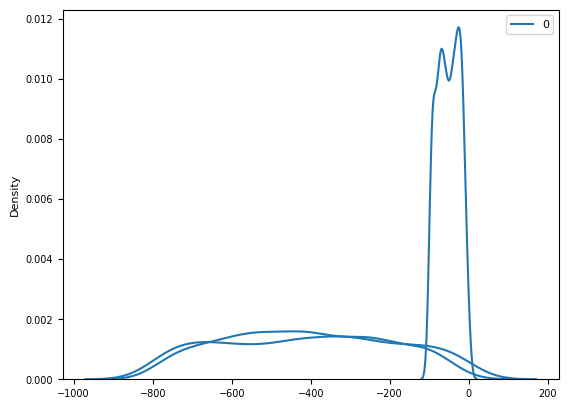

In [27]:
sns.kdeplot(restricted_proposal_no_demo.sample((1000,)))
sns.kdeplot(post_observed_65_no_demo.sample((1000,)))
sns.kdeplot(box_uniform_prior.sample((1000,)))

In [89]:

N0 = 8100 # initial effective pop size
l = [
[2*N0] * 45000,
[2*2000 * np.exp(0.015 * t) for t in range(270)],
[2*1000 * np.exp(0.05 * t) for t in range(87)], # using 5% growth
[(2*1000 * np.exp(0.05 * 87)) * np.exp(0.3 * t) for t in range(1, 13)], # using of 30% growth
]
flat_list = [item for sublist in l for item in sublist]
Nc = np.array(flat_list)/(2*N0) # moments needs pop size as floats scaled by initial effective pop size
NU_FUNC = lambda t: [Nc[int(t*2*N0)]] # creating a function to return *scaled* Ne at each time point/gen

In [29]:
moment_data = moments.LinearSystem_1D.steady_state_1D(sample_size)
moment_data = moments.Spectrum(moment_data)
moment_data.integrate(NU_FUNC, 2.8) # 2.8 is the total number of gens in pop size units


N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102


In [31]:
mom_true_fs = np.concatenate((np.asarray([0]),true_fs,np.asarray([0])))

In [35]:
data = moments.Spectrum(mom_true_fs)


In [36]:
opt_theta = moments.Inference.optimal_sfs_scaling(moment_data, data)


In [37]:
print("Optimal theta:", opt_theta)


Optimal theta: 5288.113819103699


### Estimate optimal theta for jewish ancestry

In [60]:
sample_sizes = [9762]
print("Get Real Jewish Data")
true_fs = get_true_data(sample_sizes[0], '/home/rahul/PopGen/SimulationSFS/gnomAD_data/aji_ac.vcf')
print(true_fs.shape)

Get Real Jewish Data
torch.Size([9761])


In [61]:
print("Define Moments simulator for jewish ancestory, first define demography")
sampled_demes = ["AJI"]

aji_model = '/home/rahul/PopGen/SimulationSFS/ClusterData/JewishDemo/test_AJI_demo.yml'

Define Moments simulator for jewish ancestory, first define demography


In [53]:
jewish_moment_data =  moments.Spectrum.from_demes(aji_model, sampled_demes=sampled_demes, sample_sizes=sample_sizes)

In [62]:
jewish_true_fs = np.concatenate((np.asarray([0]),true_fs.numpy(),np.asarray([0])))
jewish_mom_data = moments.Spectrum(jewish_true_fs)
print("Jewish Real data shape {}".format(jewish_mom_data.shape))

Jewish Real data shape (9763,)


In [63]:
opt_theta = moments.Inference.optimal_sfs_scaling(jewish_moment_data, jewish_mom_data)
print("Optimal theta:", opt_theta)


Optimal theta: 5708.266324278298


In [ ]:
jewish_post_observed_65_demo = torch.load('/home/rahul/PopGen/SimulationSFS/ClusterData/JewishDemo/posterior_observed_round_95.pkl')

In [40]:
print("Creating restricted proposal for Jewish Demography")
accept_reject_fn = get_density_thresholder(jewish_post_observed_65_demo, quantile=1e-6, num_samples_to_estimate_support = 10_000_000)
restricted_proposal_with_demo = RestrictedPrior(box_uniform_prior, accept_reject_fn, posterior=jewish_post_observed_65_demo, sample_with="sir", device='cpu')
print("Finished creating restricted proposal for Jewish Demography")

Creating restricted proposal for Jewish Demography
Finished creating restricted proposal for Jewish Demography


In [84]:
def moment_sim_deme(prior: float) -> torch.float32:
    """Uses Moments (cite) to create simulated Site Frequency Spectrums of a demographic history

    Args:
        prior (float): a sampled selection distribution from a prior distribution

    Returns:
        x: The sampled site-frequency spectrum based on moments via Poisson(E[X | gamma]) where gamma = prior
        Output of the simulator needs to be float32 based on SBI format 
    """    
    
    moment_data =  moments.Spectrum.from_demes(aji_model, sampled_demes=sampled_demes, sample_sizes=sample_sizes, gamma=prior)
    
    # masked arrays are objects and data is accessed through .data attribute or valid data through .compressed()
    actual_fs = moment_data.compressed() * 91.0
    x = torch.poisson(torch.tensor(actual_fs, device='cpu')).type(torch.float32)
        
    return x

In [85]:
from sbi.utils.user_input_checks import process_prior, process_simulator
prior, num_parameters, prior_returns_numpy = process_prior(box_uniform_prior)

simulator = process_simulator(moment_sim_deme, box_uniform_prior, prior_returns_numpy)


<AxesSubplot: ylabel='Density'>

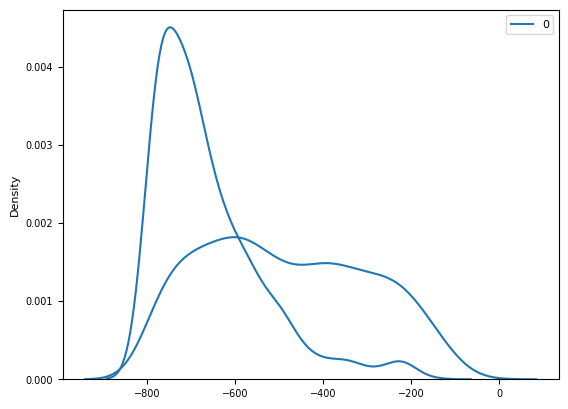

In [80]:
sns.kdeplot(restricted_proposal_no_demo.sample((1000,)))
sns.kdeplot(jewish_post_observed_65_demo.sample((1000,)))


In [81]:
propose_samples = restricted_proposal_no_demo.sample((200,)).numpy()

In [87]:
x = moment_sim_deme(-800.0)

RuntimeError: invalid Poisson rate, expected rate to be non-negative

In [92]:
### See what happens with Finnish when using optimal theta 
moments_finnish_theta= 5288
sample_size_finnish = 16734

In [104]:
def moment_sim_deme_finnish(prior: float) -> torch.float32:
    """Uses Moments (cite) to create simulated Site Frequency Spectrums of a demographic history

    Args:
        prior (float): a sampled selection distribution from a prior distribution

    Returns:
        x: The sampled site-frequency spectrum based on moments via Poisson(E[X | gamma]) where gamma = prior
        Output of the simulator needs to be float32 based on SBI format 
    """    
    moment_data = moments.LinearSystem_1D.steady_state_1D(sample_size_finnish, gamma=prior, theta=moments_finnish_theta)
    moment_data = moments.Spectrum(moment_data)
    moment_data.integrate(NU_FUNC, 2.8, gamma=prior, dt_fac=0.02, theta=moments_finnish_theta) # 2.8 is the total number of gens in pop size units
    actual_fs = moment_data.compressed()
    if np.any(actual_fs < 0):
        print("Negative frequency density")
        actual_fs = F.relu(torch.tensor(actual_fs, device='cpu'))
        x = torch.poisson(actual_fs).type(torch.float32)
    else:
        x = torch.poisson(torch.tensor(actual_fs, device='cpu')).type(torch.float32)

    return x  


In [94]:
print("loading finnish demography with theta: {}".format(moments_finnish_theta))
finnish_post_5288 = torch.load('/home/rahul/PopGen/SimulationSFS/ClusterData/Finnish/Demo/posterior_observed_round_65_theta_5000.pkl')

loading finnish demography with theta: 5288


In [96]:
print("Creating restricted proposal")
accept_reject_fn_finnish_5288 = get_density_thresholder(finnish_post_5288, quantile=1e-6, num_samples_to_estimate_support = 10_000_000)
restricted_proposal_finnish_5288 = RestrictedPrior(box_uniform_prior, accept_reject_fn_finnish_5288, posterior=finnish_post_5288, sample_with="sir", device='cpu')
print("Finished creating restricted proposal")

Creating restricted proposal
Finished creating restricted proposal


<AxesSubplot: ylabel='Density'>

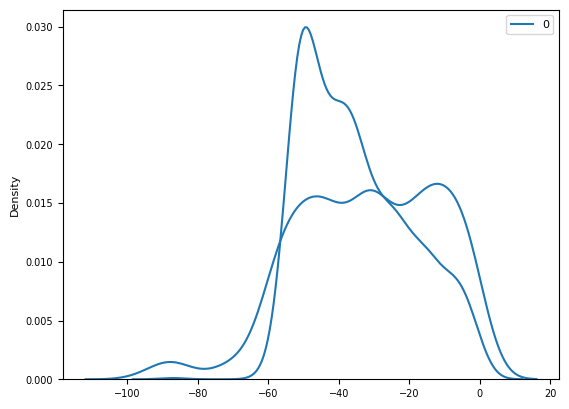

In [97]:
sns.kdeplot(restricted_proposal_finnish_5288.sample((1000,)))
sns.kdeplot(finnish_post_5288.sample((1000,)))

In [105]:
simulator_finnish = process_simulator(moment_sim_deme_finnish, box_uniform_prior, prior_returns_numpy)


In [106]:
xx = simulator_finnish(restricted_proposal_finnish_5288.sample((200,)))

N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative

N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
Negative frequency density
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911

N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
Negative frequency density
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
Negative frequency density
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.

N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]

In [126]:
D=list(range(1, 100, 10))
x_pp2 = xx[:, D]
x_o2 = finnish_true_fs[D]

In [127]:
x_pp2.shape

torch.Size([200, 10])

In [115]:
from sbi.analysis import pairplot


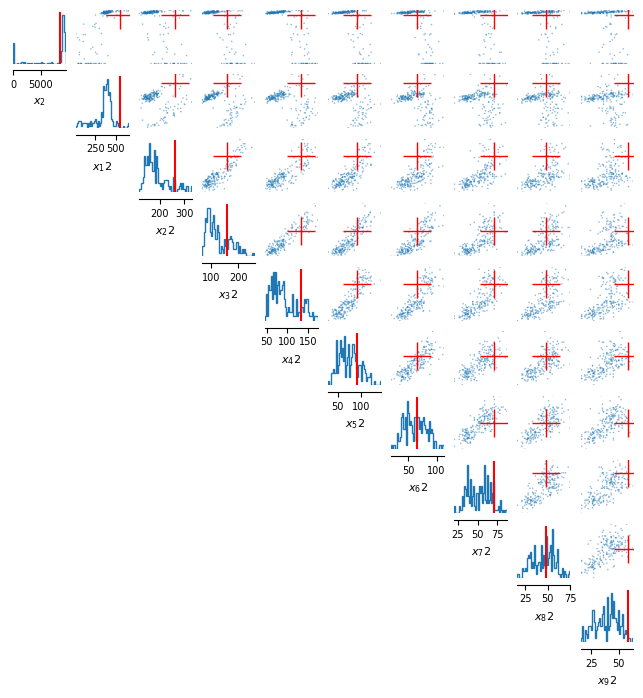

In [130]:
_ = pairplot(
    samples=x_pp2,
    points=x_o2,
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=20),
    labels=[rf"$x_{d+1}$" for d in D],)

In [153]:
xx_proposal = simulator_finnish(finnish_post_5288.sample((200,)))
x_pp2_proposal = xx_proposal[:, D]


N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]

N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
Negative frequency density
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N

N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new 

N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
Negative frequency density
Negative frequency density
Negative frequency density
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
Negative frequency density
Negative frequency density
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102


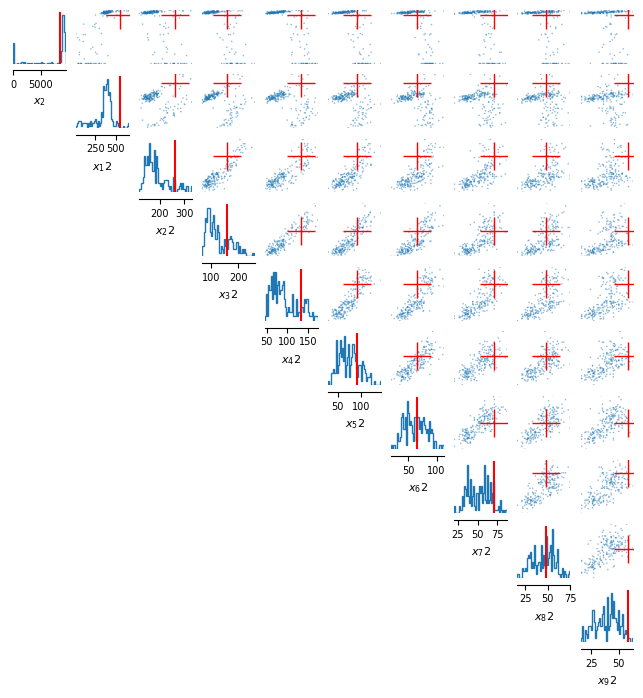

In [155]:
_ = pairplot(
    samples=x_pp2,
    points=x_o2,
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=20),
    labels=[rf"$x_{d+1}$" for d in D],)

In [181]:
def moment_sim_deme_finnish_bins(prior: float) -> torch.float32:
    """Uses Moments (cite) to create simulated Site Frequency Spectrums of a demographic history

    Args:
        prior (float): a sampled selection distribution from a prior distribution

    Returns:
        x: The sampled site-frequency spectrum based on moments via Poisson(E[X | gamma]) where gamma = prior
        Output of the simulator needs to be float32 based on SBI format 
    """    
    moment_data = moments.LinearSystem_1D.steady_state_1D(sample_size_finnish, gamma=prior, theta=moments_finnish_theta)
    moment_data = moments.Spectrum(moment_data)
    moment_data.integrate(NU_FUNC, 2.8, gamma=prior, dt_fac=0.02, theta=moments_finnish_theta) # 2.8 is the total number of gens in pop size units
    actual_fs = moment_data.compressed()
    if np.any(actual_fs < 0):
        print("Negative frequency density")
        actual_fs = F.relu(torch.tensor(actual_fs, device='cpu'))

    return actual_fs  

In [182]:
simulator_finnish_bins = process_simulator(moment_sim_deme_finnish_bins, box_uniform_prior, prior_returns_numpy)


In [157]:
bin_160 = torch.load('/home/rahul/PopGen/SimulationSFS/ClusterData/Finnish/Demo/finnish_not_parallel_SNPE_bin_figures_2022-12-16_12-11/saved_posterior_160.pkl')
bin_800 = torch.load('/home/rahul/PopGen/SimulationSFS/ClusterData/Finnish/Demo/finnish_not_parallel_SNPE_bin_figures_2022-12-16_12-17/saved_posterior_800.pkl')
bin_1600 = torch.load('/home/rahul/PopGen/SimulationSFS/ClusterData/Finnish/Demo/finnish_not_parallel_SNPE_bin_figures_2022-12-16_12-23/saved_posterior_1600.pkl')
bin_3200 = torch.load('/home/rahul/PopGen/SimulationSFS/ClusterData/Finnish/Demo/finnish_not_parallel_SNPE_bin_figures_2022-12-16_12-29/saved_posterior_3200.pkl')



In [189]:
bin_8000 = torch.load('/home/rahul/PopGen/SimulationSFS/ClusterData/Finnish/Demo/finnish_not_parallel_SNPE_bin_figures_2022-12-16_12-38/saved_posterior_8000.pkl')

In [158]:
bin_160

VIPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [160]:
import pandas as pd

In [191]:
temp = torch.cat((bin_160.sample((1000,)).unsqueeze(1), bin_800.sample((1000,)).unsqueeze(1), bin_1600.sample((1000,)).unsqueeze(1), bin_3200.sample((1000,)).unsqueeze(1), bin_8000.sample((1000,)).unsqueeze(1)), dim=1)
temp = temp.squeeze()
print(temp.shape)
df = pd.DataFrame(temp.numpy(), columns=['160', '800', '1600', '3200', '8000'])


torch.Size([1000, 5])


In [193]:
df2 = pd.DataFrame(np.log(np.abs(temp.numpy())), columns=['160', '800', '1600', '3200', '8000'])


In [194]:
df2.head()

,160,800,1600,3200,8000
0,4.579512,4.573180,4.575836,4.591183,3.289736
1,4.561129,4.591376,4.586406,4.578386,4.169603
2,4.584705,4.599149,4.559916,4.599893,3.835332
3,4.578991,4.568731,4.571582,4.592009,2.281153
4,4.582048,4.569178,4.580599,4.571156,3.252167


Text(0, 0.5, 'Log scale of Gamma')

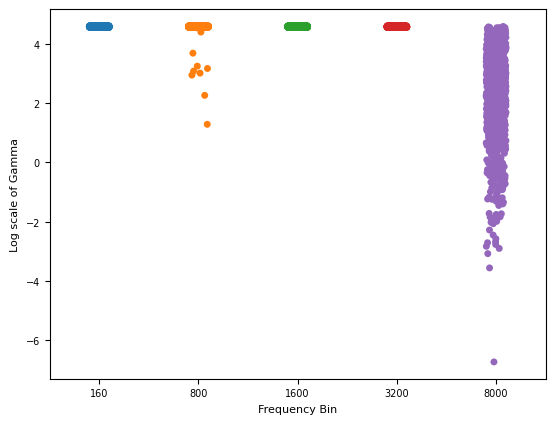

In [195]:
sns.stripplot(data=df2)
plt.xlabel('Frequency Bin')
plt.ylabel('Log scale of Gamma')
#plt.hist(np.log(np.abs(temp.numpy())), label=['160', '800', '1600', '3200'])
#plt.legend()

In [183]:
bins_xx = simulator_finnish_bins(bin_160.sample((200,)))

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
re

N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_n

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
r

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative 

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.2469135

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
r

In [184]:
bins_xx_800 = simulator_finnish_bins(bin_800.sample((200,)))
bins_xx_1600 = simulator_finnish_bins(bin_1600.sample((200,)))
bins_xx_3200 = simulator_finnish_bins(bin_3200.sample((200,)))

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
re

N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.753086419

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.99

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
Negative frequency density
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relativ

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599

N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.991157159943410

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.

N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relat

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative 

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.99

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_n

N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relati

N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_n

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.99

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121

N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.

N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
relative change 0.0
N_old,  [13.96121487] N_new [0.12345679]
relative change 0.9911571599434102
N_old,  [1.] N_new [1.]
relative change 0.0
N_old,  [1.] N_new [0.24691358]
relative change 0.7530864197530864
N_old,  [13.96121487] N_new [13.96121487]
r

In [185]:
all_bins = torch.cat((bins_xx, bins_xx_800, bins_xx_1600, bins_xx_3200),dim=0)

In [186]:
all_bins.shape

torch.Size([800, 16733])

In [ ]:
_ = pairplot(
    samples=bins_xx,
    points=finnish_true_fs[160],
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=20),
    labels=[rf"$x_{160}$"],)

In [ ]:
_ = pairplot(
    samples=bins_xx_800,
    points=finnish_true_fs[800],
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=20),
    labels=[rf"$x_{160}$"],)

In [ ]:
_ = pairplot(
    samples=bins_xx_1600,
    points=finnish_true_fs[1600],
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=20),
    labels=[rf"$x_{160}$"],)

In [ ]:
_ = pairplot(
    samples=bins_xx_3200,
    points=finnish_true_fs[3200],
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=20),
    labels=[rf"$x_{160}$"],)